In [1]:
'''pip install emoji'''

'pip install emoji'

In [2]:
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from pathlib import Path
from nltk.util import ngrams
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
file_path = '../data/haspeede2_dev/haspeede2_dev_taskAB.tsv'
df = pd.read_csv(file_path, sep='\t', on_bad_lines='warn')
df

,id,text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0
...,...,...,...,...
6832,9340,Gli stati nazionali devono essere pronti a rin...,0,0
6833,9121,Il ministro dell'interno della Germania #Horst...,0,0
6834,8549,#Salvini: In Italia troppi si sono montati la ...,0,0
6835,9240,@user @user Chi giubila in buona fede non ha c...,0,0


In [5]:
# Pulizia del dataset da cose inutili all'analisi delle emoji
df['text '] = df['text '].str.replace(r'@user', '', regex=True)
df['text '] = df['text '].str.replace(r'URL', '', regex=True)
df['text '] = df['text '].str.replace(r'#\S+', '', regex=True)
df['text '] = df['text '].str.replace(r'�', '', regex=True)
df


,id,text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,infatti finché ci hanno guadagnato con i cam...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"ad uno ad uno, perché quando i migranti israe...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0
...,...,...,...,...
6832,9340,Gli stati nazionali devono essere pronti a rin...,0,0
6833,9121,Il ministro dell'interno della Germania facen...,0,0
6834,8549,"In Italia troppi si sono montati la testa, io...",0,0
6835,9240,Chi giubila in buona fede non ha capito nien...,0,0


In [6]:
# trovare gli emoticon
emoticon_pattern = r'[:;=8xX][\-~]?[)\](DdpP3oO|/\\*<>]'
df['emoticons'] = df['text '].str.findall(emoticon_pattern).str.join(' ') # eliminare gli emoticon dai tweet e inserirli nella colonna emoticons

In [7]:
df

,id,text,hs,stereotype,emoticons
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0,
1,2045,infatti finché ci hanno guadagnato con i cam...,0,0,
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0,
3,1259,"ad uno ad uno, perché quando i migranti israe...",0,0,
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0,
...,...,...,...,...,...
6832,9340,Gli stati nazionali devono essere pronti a rin...,0,0,
6833,9121,Il ministro dell'interno della Germania facen...,0,0,
6834,8549,"In Italia troppi si sono montati la testa, io...",0,0,
6835,9240,Chi giubila in buona fede non ha capito nien...,0,0,


# estrazione emoji

1.   Estraggo le emoji
2.   Le elimino dai tweet
3.   Inserisco le emoji estratte nella colonna emoji




In [8]:
emoji_whitelist = ["▶️", "‼️", "⁉️"]

# Funzione per estrarre emoji
def extract_emojis(text):
    if not text:
        return ''
    # Regex
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Simboli e pittogrammi
        u"\U0001F680-\U0001F6FF"  # Trasporti
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"  # Simboli geometrici estesi
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"  # Faccine estese
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F1E0-\U0001F1FF"  # Bandiere
        u"\U00002700-\U000027BF"  # Simboli vari
        u"\U00002600-\U000026FF"  # Simboli come ☀️ e ⚡
        u"\U00002300-\U000023FF"  # Simboli extra
        u"\U00002B00-\U00002BFF"  # Frecce e simboli geometrici
        "]",
        flags=re.UNICODE,
    )
    # Combina whitelist e regex
    whitelist_pattern = re.compile('|'.join(map(re.escape, emoji_whitelist)))
    combined_pattern = re.compile(f"{emoji_pattern.pattern}|{whitelist_pattern.pattern}")
    return ''.join(combined_pattern.findall(text))

df['emojis'] = df['text '].apply(extract_emojis)

# Rimozione delle emoji dal testo
def remove_emojis(text):
    if not text:
        return text
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U00002600-\U000026FF"
        u"\U00002300-\U000023FF"
        u"\U00002B00-\U00002BFF"
        "]",
        flags=re.UNICODE,
    )
    whitelist_pattern = re.compile('|'.join(map(re.escape, emoji_whitelist)))
    combined_pattern = re.compile(f"{emoji_pattern.pattern}|{whitelist_pattern.pattern}")
    return combined_pattern.sub('', text)

df['text '] = df['text '].apply(remove_emojis)

# Rimozione degli spazi
df['text '] = df['text '].str.strip().str.replace(r'\s+', ' ', regex=True)



# Frequenze delle emoji
all_emojis = ''.join(df['emojis'])
emoji_frequencies = Counter(all_emojis)

sorted_emoji_frequencies = dict(sorted(emoji_frequencies.items(), key=lambda item: item[1], reverse=True))
emoji_df = pd.DataFrame(sorted_emoji_frequencies.items(), columns=['Emoji', 'Frequenza'])
top_10_emojis = emoji_df.head(10)
fig = px.bar(top_10_emojis, x='Emoji', y='Frequenza', title='Top 10 Frequenze delle Emoji')
fig.show()

#Cre una nuova colonna dove unisco i risultati di "emoticons" e "emoji"

In [9]:
df['all_emoticons_emojis'] = df['emoticons'] + ' ' + df['emojis']
df['all_emoticons_emojis'] = df['all_emoticons_emojis'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Elimino le due colonne ormai superflue

In [10]:
df.drop(columns=['emoticons', 'emojis'], inplace=True)

In [11]:
df

,id,text,hs,stereotype,all_emoticons_emojis
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0,
1,2045,infatti finché ci hanno guadagnato con i campi...,0,0,
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0,
3,1259,"ad uno ad uno, perché quando i migranti israel...",0,0,
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0,
...,...,...,...,...,...
6832,9340,Gli stati nazionali devono essere pronti a rin...,0,0,
6833,9121,Il ministro dell'interno della Germania facend...,0,0,
6834,8549,"In Italia troppi si sono montati la testa, io ...",0,0,
6835,9240,Chi giubila in buona fede non ha capito niente...,0,0,


In [12]:
print(df['all_emoticons_emojis'].unique())

['' ':)' '😲' '✌' '😠' '🙄' '😁' ':D' '83' '😑' 'xo' 'xp' '😂😂' '☺' '👍🏼' '=\\'
 '8o' '😳🙄🤔🤓😂😂😂😂😂' '😡' '😄😄😄😄😄😄' '🤔🤔🤔' '🇬🇧' '✳✳' '❤' '🔥🔥' ':3' '🇮🇹' '😅' '😳'
 '🤕' '😳😳😉' ':-(' '😢' '😊👍' '🔹❓🔹🇮🇹❓' '👎' '💖' ':(' ':d' '😈' '👌' '😂😂😂😂😂😂' '8)'
 '😱😱😱' '👹' '🌿🌿' '🤔' '😂🙈' '⛔⛔⛔' '🤔😂' '😀👍✌' ':p' '📍' '😁😁😁' '😜' 'xP' '💣💥' '👍'
 '💩💩💩💩' '😒' '😷' '🕌💥🌍🤡🕋' '👏😡' 'XD' ':/' '🖒' ':o' '😥' '🙄🙄' '🔴🔴👇🏿' '💩💩' '🙄🤔🤨'
 '😣😣' '‼️⁉️' '🇮🇹🤔💥🇮🇹' ';p' '💩' '😤' '🤦♀🤦♀🤣🤣🤣🤣' '🤣🤣🤣😂😂😂😁😁😁' '😂😂😂😂😂😎'
 '😂😂😂🖕🖕🖕' '😠😠😠😠😠😠' '🖕🖕🖕🖕🖕' '❗😡❗❗😬❗' '🤮' '😂' '💬' '🍸' '🇪🇺🇮🇹' '🌈🌈🤪✊🏻' '🌟🌟🌟🌟🌟'
 '😐' ';P' '🤔😡👿' '🔹🔹🔹' '😘' '😠😠' '🤚' '😤😤😤😤' '🤨😟😡😡😡😡🇮🇹🇮🇹🇮🇹✌✌' '❌❌❌❌' '😀😀'
 '😄😄👋🏻' '😡😡😡' '😈😭😫' '💔😭' '🚫' '✋' '🌹' '✂' '📆📍📢' '😊' '😎' '🇮🇹👍' '🤣🤣🤣' '👉🏻'
 '🤣🤣' '🤣' '📺' '🔽▶️' '😤🤔' '👍👍👏👏😊' '💃💃💃👉👈' '🇮🇹🤮🇫🇷' '🙈🙈' '😨' '😂😂😂😂💩💩' '✊'
 '🤦♀🤦♀🤦♀🤦♀🤦♀' '✍➡' '🙄👿' '👏' '👏👏👏' '👇' '🇮🇹🇮🇹' '🤔🇪🇺🇮🇹🇪🇺🇮🇹🇪🇺🇮🇹🇪🇺🇮🇹🇪🇺' '😁😂'
 '😡😡' '😁😉' '🇮🇹🇮🇹🇮🇹' '👍👍👍👍👏👏👏👏👏👿👿👿👿👿👿' '🙈🤦♂' '🤬🤦♀' '🖕🏿👎🏿' '😒😑😒' '😔😷' '😣😣😣'
 '🔴' '🇮🇹🤫' '😬😳😩😤' '‼️‼️👊' '😂🙄' '🦅' '😁😁😁⌨' '✔✔✔✔✔✔✔😂😂😂😂' '👎👎' '☪✝😱'
 '🤢🤢👿👿🤕🤕😨😨😨' '👎👎👎✋' '🍷🍺' '👀😬' '😱' '💩💩😡😡😡' '😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡'

# Esplorazione emoji più usate

In [13]:
total_tweets = len(df)
tweets_with_emojis = len(df[df['all_emoticons_emojis'] != ''])
percent_with_emojis = (tweets_with_emojis / total_tweets) * 100
print(f"Percentuale di tweet con emoji: {percent_with_emojis:.2f}%")

emoji_df = pd.DataFrame(emoji_frequencies.items(), columns=['Emoji', 'Frequenza'])
fig = px.bar(emoji_df.sort_values(by='Frequenza', ascending=False), x='Emoji', y='Frequenza', title='Frequenza di tutte le Emoji')
fig.show()


Percentuale di tweet con emoji: 4.90%


# CORRELAZIONI TRA EMOJI E VARIABILI

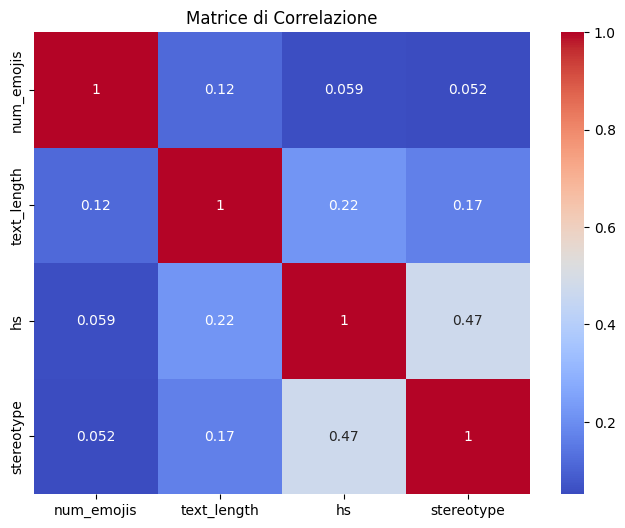

In [14]:
df['num_emojis'] = df['all_emoticons_emojis'].apply(lambda x: len(x.split()))  # Conta emoji
df['text_length'] = df['text '].apply(len)  # Lunghezza del testo

correlation_matrix = df[['num_emojis', 'text_length', 'hs', 'stereotype']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice di Correlazione')
plt.show()


# INIZIO PROCEDURA TF-IDF

In [15]:
def remove_duplicates(text):
    if not text:
        return ''
    seen = set()
    return ''.join([char for char in text if not (char in seen or seen.add(char))])

df['unique_emojis'] = df['all_emoticons_emojis'].apply(remove_duplicates)


In [16]:
df.drop(columns=['num_emojis'], inplace=True)
df.drop(columns=['text_length'], inplace=True)

In [17]:
# Emoticon più comuni
emoticon_pattern = re.compile(r"""
    (?:
    :\)|:-\)|\(:|\(-:     # Sorriso
    |:\(|:-\(|\):|\)-:     # Triste
    |:D|:-D|D:|D-:         # Risata
    |;\)|;-\)|\(;|\(-;     # Occhiolino
    |:'\(|:'-\(            # Piangente
    |:P|:-P|P:|P-:         # Giocoso
    |:o|:-o|O:|O-:         # Sorpreso
    |XD|X-D                # Risata forte
    |:/|:-/                # Confuso
    )
""", re.VERBOSE)

# Mapping delle emoticon più comuni
def emoticon_to_name(emoticon):
    emoticon_dict = {
        ":)": "smile",
        ":-)": "smile",
        "(:": "smile",
        "(-:": "smile",
        ":(": "sad",
        ":-(": "sad",
        "):": "sad",
        ")-:": "sad",
        ":D": "laugh",
        ":-D": "laugh",
        "D:": "laugh",
        "D-:": "laugh",
        ";)": "wink",
        ";-)": "wink",
        "(;": "wink",
        "(-;": "wink",
        ":'(": "cry",
        ":'-(": "cry",
        ":P": "playful",
        ":-P": "playful",
        "P:": "playful",
        "P-:": "playful",
        ":o": "surprised",
        ":-o": "surprised",
        "O:": "surprised",
        "O-:": "surprised",
        "XD": "laughing_hard",
        "X-D": "laughing_hard",
        ":/": "confused",
        ":-/": "confused"
    }
    return emoticon_dict.get(emoticon, "unknown_emoticon")

# Trasformo le emoji e le emoticon in nomi
def convert_to_names(text):
    if not text:
        return ''
    text = emoji.demojize(text)
    text = re.sub(r':(.*?):', lambda m: f"{m.group(1)} ", text)
    text = re.sub(emoticon_pattern, lambda m: emoticon_to_name(m.group()), text)
    return text.strip()

df['emojis_names'] = df['all_emoticons_emojis'].apply(convert_to_names)

# TROVARE GLI N-GRAMMI POSSIBILI

In [18]:
# Funzione per trovare gli n-grammi dato un elenco di nomi di emoji
def find_emoji_name_ngrams(emoji_name_list, n):
    return list(ngrams(emoji_name_list, n))

# Funzione per generare n-grammi per una gamma di valori n
def generate_ngrams_for_range(emoji_name_list, min_n=1, max_n=5):
    ngram_counters = {n: Counter() for n in range(min_n, max_n + 1)}

    for n in range(min_n, max_n + 1):
        ngrams_list = find_emoji_name_ngrams(emoji_name_list, n)
        ngram_counters[n].update(ngrams_list)

    return ngram_counters

# Trasforma la colonna `emojis_names` in liste di parole
df['emoji_name_list'] = df['emojis_names'].apply(lambda x: x.split())

# Parametri
min_n = 1
max_n = 5

# Generazione automatica degli n-grammi
all_ngrams = {n: Counter() for n in range(min_n, max_n + 1)}
for emoji_name_list in df['emoji_name_list']:
    ngram_counters = generate_ngrams_for_range(emoji_name_list, min_n, max_n)
    for n in range(min_n, max_n + 1):
        all_ngrams[n].update(ngram_counters[n])

# Mostra i migliori n-grammi
print("\nTop n-grammi per ogni valore di n:")
for n in range(min_n, max_n + 1):
    print(f"\nTop {n}-grammi:")
    for ngram, freq in all_ngrams[n].most_common(5):  # Top 5 n-grammi per ogni n
        print(f"{' '.join(ngram)}: {freq}")

# Trova il valore ottimale di n
optimal_n = max(all_ngrams, key=lambda n: sum(all_ngrams[n].values()))
print(f"\nIl valore ottimale di n (basato sulla frequenza totale): {optimal_n}")

#Grafico
optimal_ngrams = all_ngrams[optimal_n]
optimal_ngrams_df = pd.DataFrame(optimal_ngrams.items(), columns=['N-gram', 'Frequency']).sort_values(by='Frequency', ascending=False)
optimal_ngrams_df['N-gram'] = optimal_ngrams_df['N-gram'].apply(lambda x: ' '.join(x))

fig = px.bar(
    optimal_ngrams_df.head(10),
    x='N-gram',
    y='Frequency',
    title=f'Top {optimal_n}-grammi nei Nomi delle Emoji',
    labels={'N-gram': f'{optimal_n}-gramma', 'Frequency': 'Frequenza'}
)
fig.show()



Top n-grammi per ogni valore di n:

Top 1-grammi:
enraged_face: 70
face_with_tears_of_joy: 57
Italy: 34
rolling_on_the_floor_laughing: 27
beaming_face_with_smiling_eyes: 25

Top 2-grammi:
enraged_face enraged_face: 42
face_with_tears_of_joy face_with_tears_of_joy: 33
rolling_on_the_floor_laughing rolling_on_the_floor_laughing: 16
beaming_face_with_smiling_eyes beaming_face_with_smiling_eyes: 13
pile_of_poo pile_of_poo: 11

Top 3-grammi:
enraged_face enraged_face enraged_face: 29
face_with_tears_of_joy face_with_tears_of_joy face_with_tears_of_joy: 22
rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing: 9
beaming_face_with_smiling_eyes beaming_face_with_smiling_eyes beaming_face_with_smiling_eyes: 7
angry_face_with_horns angry_face_with_horns angry_face_with_horns: 6

Top 4-grammi:
enraged_face enraged_face enraged_face enraged_face: 18
face_with_tears_of_joy face_with_tears_of_joy face_with_tears_of_joy face_with_tears_of_joy: 12
person_facepalmin

# TF-IDF

In [19]:
# Estrazion solo dei nomi delle emoji da `emojis_names`
def extract_emoji_names_only(text):
    return ' '.join(re.findall(r"\b\w+\b", text))  # Mantiene solo parole alfanumeriche

df['emoji_name_text'] = df['emojis_names'].apply(extract_emoji_names_only)

# Calcolo di TF-IDF sui nomi delle emoji
def calculate_tfidf_on_emoji_names(texts, min_n=1, max_n=3):
    vectorizer = TfidfVectorizer(ngram_range=(min_n, max_n), token_pattern=r'\b\w+\b') # genero gli n-grammi e calcolare TF-IDF
    X = vectorizer.fit_transform(texts)
    ngrams = vectorizer.get_feature_names_out()

    # Calcolo la media di TF-IDF per ogni n-gramma
    tfidf_values = np.mean(X.toarray(), axis=0)

    tfidf_df = pd.DataFrame({
        'N-gram': ngrams,
        'TF-IDF': tfidf_values
    }).sort_values(by='TF-IDF', ascending=False)

    return tfidf_df

# Eseguo TF-IDF sui tutti i nomi delle emoji
texts = df['emoji_name_text'].tolist()
tfidf_results = calculate_tfidf_on_emoji_names(texts, min_n=1, max_n=3)

# Risultati
print("Top N-grammi sui nomi delle emoji (TF-IDF):")
print(tfidf_results.head(10))

# Grafico
fig = px.bar(
    tfidf_results.head(10),
    x='N-gram',
    y='TF-IDF',
    title='Top N-grammi sui Nomi delle Emoji con TF-IDF',
    labels={'N-gram': 'N-gramma', 'TF-IDF': 'TF-IDF'}
)
fig.show()


Top N-grammi sui nomi delle emoji (TF-IDF):
                             N-gram    TF-IDF
101                    enraged_face  0.003181
244                           italy  0.002182
161          face_with_tears_of_joy  0.002172
431                   thinking_face  0.001885
499                              xo  0.001316
334                     pile_of_poo  0.001268
372   rolling_on_the_floor_laughing  0.001136
37   beaming_face_with_smiling_eyes  0.001036
85                                d  0.001024
104       enraged_face enraged_face  0.000979


# Emoji Dominanti nei Tweet

In [20]:
# Nomi delle emoji
emoji_names = df['emoji_name_text'].dropna().str.split().explode()

# Calcola della frequenza delle emoji
emoji_freq = Counter(emoji_names)

emoji_freq_df = pd.DataFrame(emoji_freq.items(), columns=['Emoji Name', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Top 20
fig = px.bar(
    emoji_freq_df.head(20),
    x='Emoji Name',
    y='Frequency',
    title='Top 20 Emoji nei Tweet',
    labels={'Emoji Name': 'Nome Emoji', 'Frequency': 'Frequenza'}
)
fig.show()

# SENTIMET ANALYSIS

In [21]:
# Confronto delle emoji con HS e senza HS
def compare_emoji_sentiment(df):
    hate_speech = df[df['hs'] > 0]
    no_hate_speech = df[df['hs'] == 0]

    hs_emoji_names = hate_speech['emoji_name_text'].dropna().str.split().explode()
    nhs_emoji_names = no_hate_speech['emoji_name_text'].dropna().str.split().explode()

    hs_freq = Counter(hs_emoji_names)
    nhs_freq = Counter(nhs_emoji_names)

    hs_df = pd.DataFrame(hs_freq.items(), columns=['Emoji Name', 'Frequency']).sort_values(by='Frequency', ascending=False)
    nhs_df = pd.DataFrame(nhs_freq.items(), columns=['Emoji Name', 'Frequency']).sort_values(by='Frequency', ascending=False)

    return hs_df, nhs_df

hs_df, nhs_df = compare_emoji_sentiment(df)

# TOP 10
fig_hs = px.bar(hs_df.head(10), x='Emoji Name', y='Frequency', title='Top 10 Emoji nei Tweet con Hate Speech', labels={'Emoji Name': 'Nome Emoji', 'Frequency': 'Frequenza'})
fig_nhs = px.bar(nhs_df.head(10), x='Emoji Name', y='Frequency', title='Top 10 Emoji nei Tweet senza Hate Speech', labels={'Emoji Name': 'Nome Emoji', 'Frequency': 'Frequenza'})

fig_hs.show()
fig_nhs.show()

# CLUSTERING EMOJI

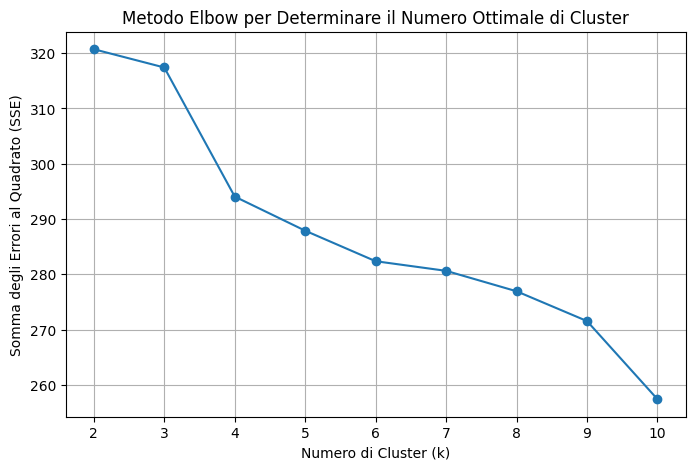

In [22]:
# Clustering sui TF-IDF
vectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
tfidf_matrix = vectorizer.fit_transform(df['emoji_name_text'].dropna())

# Elbow per trovare  il k ottimale
sse = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

# Grafico
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.title('Metodo Elbow per Determinare il Numero Ottimale di Cluster')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Somma degli Errori al Quadrato (SSE)')
plt.grid()
plt.show()



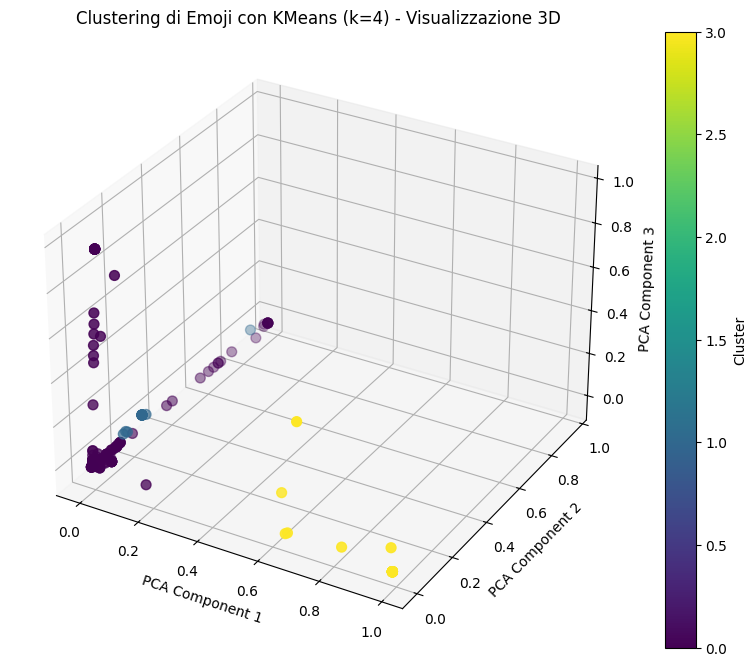

In [23]:
# Applicazione del cluster
vectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
tfidf_matrix = vectorizer.fit_transform(df['emoji_name_text'].dropna())

# K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(tfidf_matrix)

# 3D
pca = PCA(n_components=3)
reduced_data_3d = pca.fit_transform(tfidf_matrix.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_data_3d[:, 0],
    reduced_data_3d[:, 1],
    reduced_data_3d[:, 2],
    c=kmeans.labels_,
    cmap='viridis',
    s=50
)
ax.set_title(f'Clustering di Emoji con KMeans (k=4) - Visualizzazione 3D')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter, label='Cluster')
plt.show()

# TOPIC MODELING

In [24]:
# LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# 4 Topic
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}: {', '.join([terms[i] for i in topic.argsort()[-10:]])}")

Topic 0: smiling_face_with_smiling_eyes, grinning_face_with_smiling_eyes, smiling_face, face_screaming_in_fear, fearful_face, face_with_steam_from_nose, clapping_hands, thumbs_up, angry_face, pile_of_poo
Topic 1: neutral_face, winking_face, laugh, 83, face_vomiting, flushed_face, red_circle, beaming_face_with_smiling_eyes, italy, face_with_tears_of_joy
Topic 2: double_exclamation_mark, winking_face_with_tongue, face_blowing_a_kiss, sparkling_heart, face_with_symbols_on_mouth, grinning_face, xp, face_with_medical_mask, xo, thinking_face
Topic 3: astonished_face, middle_finger, angry_face_with_horns, expressionless_face, backhand_index_pointing_down, smiling_face_with_sunglasses, smile, thumbs_down, rolling_on_the_floor_laughing, enraged_face
Topic 4: female_sign, small_blue_diamond, person_facepalming, persevering_face, crying_face, p, loudly_crying_face, smiling_face_with_horns, d, face_with_rolling_eyes
